# Convex hulls...
https://stackoverflow.com/questions/16750618/whats-an-efficient-way-to-find-if-a-point-lies-in-the-convex-hull-of-a-point-cl

In [1]:
import time
import numpy as np
import scipy.stats as stats
import math
import random
from collections import defaultdict
import os
import sys
from collections import Counter
import glob 
import warnings
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import importlib
from astropy.time import Time


In [202]:

def in_hull(p, cloud):
    """
    Test if points in `p` are inside `hull` of `cloud`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    assert cloud.ndim == 2 
    # Delaunay triangulation of entire cloud of points
    d = Delaunay(cloud)
    # Get the points within the convex hull 
    hullpoints = d.points[d.convex_hull].reshape( (-1,2)  )
    
    # Get the Delaunay triangulation of just the points within the convex hull 
    # Then see whether the points, `p`, are inside that convex hull
    return Delaunay(hullpoints).find_simplex(p)>=0

def in_hull_symmetric(a, b):
    ''' version of in_hull, but check both directions '''
    from scipy.spatial import Delaunay
    assert a.ndim == 2 
    assert b.ndim == 2 
    # Delaunay triangulation of supplied points
    a_d = Delaunay(a)
    b_d = Delaunay(b)
    # Get the points within the convex hull of each 
    a_h = a_d.points[a_d.convex_hull].reshape( (-1,2)  )
    b_h = b_d.points[b_d.convex_hull].reshape( (-1,2)  )
    # Get the Delaunay triangulation of just the points within the convex hull 
    # Then check whether the other supplied points are inside that convex hull
    return np.any(Delaunay(a_h).find_simplex(b)>=0) or  np.any(Delaunay(b_h).find_simplex(a)>=0)

def plot_in_hull(p, cloud):
    """
    plot relative to `in_hull` for 2d data
    """
    import matplotlib.pyplot as plt
    from matplotlib.collections import PolyCollection, LineCollection
    
    # Get Delaunay triangulation of convex hull: Copy of logic from *in_hull*
    from scipy.spatial import Delaunay
    assert cloud.ndim == 2 
    d = Delaunay(cloud)
    d = Delaunay(d.points[d.convex_hull].reshape( (-1,2)  ) )
    
    # plot triangulation of hull
    poly = PolyCollection(d.points[d.vertices], facecolors='w', edgecolors='b')
    plt.clf()
    plt.title('in hull')
    plt.gca().add_collection(poly)
    plt.plot(d.points[:,0], d.points[:,1], 'o')#, hold=1)

    # plot the convex hull
    edges = set()
    edge_points = []

    def add_edge(i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(d.points[ [i, j] ])

        
    for ia, ib in d.convex_hull:
        add_edge(ia, ib)

    lines = LineCollection(edge_points, color='g', label='Hull of cloud')
    plt.gca().add_collection(lines)

    # Find which points are inside the hull         
    inside = in_hull(p,cloud)

    # plot tested points `p` - black are inside hull, red outside
    plt.plot(p[ inside,0],p[ inside,1],'ok', label='$N_{in}=%d$' % len(p[ inside,0]) )
    plt.plot(p[~inside,0],p[~inside,1],'or', label='$N_{out}=%d$' % len(p[~inside,0]) )
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
    #plt.show()    


# function to test whether point(s) are within hull of cloud 

None
CPU times: user 33 ms, sys: 6.18 ms, total: 39.2 ms
Wall time: 39 ms


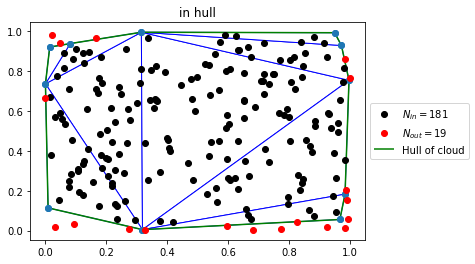

In [203]:
%%time 
tested = np.random.rand(200,2)
cloud  = np.random.rand(150,2)
print(plot_in_hull(tested,cloud))


# Covariance Matrix ...

In [204]:
# Plotting CoV Ellipse ...
# - https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [205]:
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

def alt_ellipse(x,y,ax, nstd=1):
    
    cov = np.cov(x, y) 
    vals, vecs = eigsorted(cov) 
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=w, height=h,
                  angle=theta, color='black')
    ell.set_facecolor('none')
    
    return ax.add_artist(ell)

In [206]:
def xy_ell(a,b,phi=0,n=20):
    # Axis-aligned ellipse
    t = 2*np.pi*np.sort(np.arange(n)/n) 
    XY = a*np.cos(t), b*np.sin(t) 
    # Rotate ellipse
    c, s = np.cos(phi), np.sin(phi)
    R = np.array(((c, -s), (s, c)))
    return R.dot(XY)

def another_ellipse( mean, cov , scale,n=20):
    # Sorted eig-vals & vecs: semi-major axis first
    vals, vecs = eigsorted(cov) 
    phi  = np.arctan2(*vecs[:,0][::-1])
    a, b = np.sqrt(vals)
    # Scale the rotated ellipse & translate to required center 
    return scale*xy_ell(a,b,phi=phi,n=n)+np.asarray(mean)[:,None]


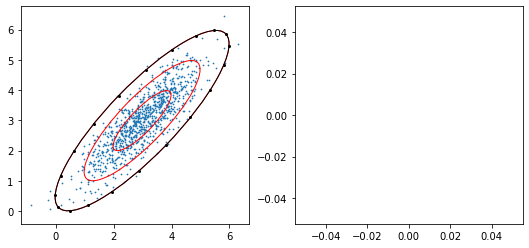

In [207]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# Define mean & CoV
mean = [3,3]
cov = [[1, 0.85], 
       [0.85, 1]]  

# Create samples 
n = int(1e3)
x,y =  np.random.multivariate_normal(mean, cov, n).T

# Plot Samples 
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].scatter(x, y, s=0.5)

# Create & plot confidence ellipse 
for n_std in range(1,4):
    confidence_ellipse(x,y, axs[0],n_std=n_std,  edgecolor='red')

# MJP : Alternative method plotting over the top ...  
alt_ellipse(x,y,axs[0], nstd=3 )

# MJP: Yet another alternative, this time using points from explicit ellipse equation
# - Just checking that I understand what is going on...
# NB If you pass in the specified mean & cov directly, it will be close-to, but not exactly the same as ...
# the actual mean & covariance of x,y, with the approximation getting worse as n gets lower
axs[0].plot(*another_ellipse( [np.mean(x),np.mean(y)], np.cov(x, y) , 3),'o', ms=2, c='k')

plt.axis('equal')
plt.show()

# Ellipse overlap for pCheck
 - Math is hard 
 - So try brute force ...
 - For overlap of two ellipses, try grid of points around edge & then convex hull 
 - At the margin it can be asymmetric, so may be worth evaluating both AinB and BinA

True


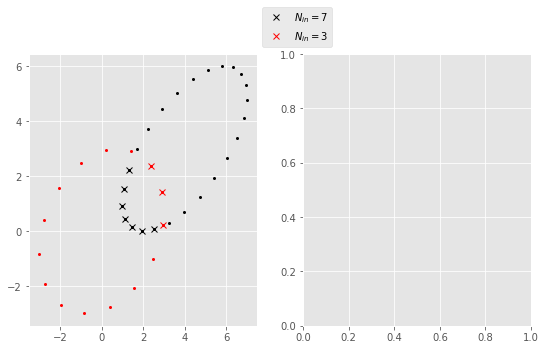

In [446]:
# Ellipses ...
mean1 = [4,3]
cov1 = [[1, 0.65], 
       [0.65, 1]]  
mean2 = [0,0]
cov2 = [[1, 0.25], 
       [0.25, 1]]  


fig, axs = plt.subplots(1, 2, figsize=(9, 5))

# Plot basic ellipses ...
XY1 = another_ellipse( mean1, cov1 , 3, n=25)
XY2 = another_ellipse( mean2, cov2 , 3, n=15)
axs[0].plot(*XY1,'o', ms=2, c='k')
axs[0].plot(*XY2,'o', ms=2, c='r')


# Find which points are inside the hull         
inside_1in2 = in_hull(XY1.T,XY2.T)
inside_2in1 = in_hull(XY2.T,XY1.T)
print(in_hull_symmetric(XY1.T,XY2.T))

# plot tested points `p` - black are inside hull, red outside
axs[0].plot(XY1.T[ inside_1in2,0],XY1.T[ inside_1in2,1],'xk', label='$N_{in}=%d$' % len(XY1.T[ inside_1in2,0]) )
axs[0].plot(XY2.T[ inside_2in1,0],XY2.T[ inside_2in1,1],'xr', label='$N_{in}=%d$' % len(XY2.T[ inside_2in1,0]) )

axs[0].legend(loc='center left', bbox_to_anchor=(1, 1.1)) 



# Random point on 3D ellipsoid 
    https://stackoverflow.com/questions/56404399/how-to-generate-a-random-sample-of-points-from-a-3-d-ellipsoid-using-python

In [223]:
def random_point_ellipsoid(a,b,c, n):
        u = np.random.rand(n)
        v = np.random.rand(n)
        theta = u * 2.0 * np.pi
        phi = np.arccos(2.0 * v - 1.0)
        sinTheta = np.sin(theta);
        cosTheta = np.cos(theta);
        sinPhi = np.sin(phi);
        cosPhi = np.cos(phi);
        rx = a * sinPhi * cosTheta;
        ry = b * sinPhi * sinTheta;
        rz = c * cosPhi;
        return rx, ry, rz

In [224]:
# Set equal axes ...
# https://stackoverflow.com/questions/8130823/set-matplotlib-3d-plot-aspect-ratio/12371373
def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

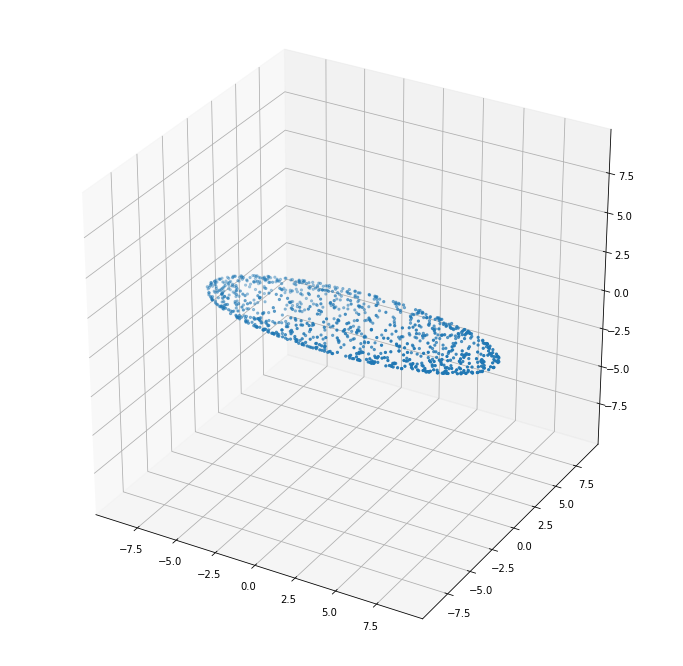

In [225]:
fig = plt.figure(figsize=3.0*plt.figaspect(1.0)*1.0)
ax = fig.add_subplot(111, projection='3d')

a,b,c = 9,3,1
x,y,z=random_point_ellipsoid(a,b,c, 1000)
ax.scatter(x,y,z, marker='.')
axisEqual3D(ax)

### Combinations & Sampling Points on an N-D Ellilsoid
 - If have an N-dimensional ellipsoid ...
 
 $(x/a)^2 + (y/b)^2+(z/c)^2 + (u/d)^2+(v/e)^2 + (w/f)^2 = 1$

#### (A) Set N-1 dimensions == 0, leaving just points on axis
 - E.g. 
 
 $\Rightarrow$
 
 $(x/a)^2 = 1$, when $y = z = u = v = w = 0$
 
 - So we have the 2 points on each axis, giving us $2N$ points
 
 
#### (B) Set N-2 dimensions == 0, leaving eqn for 2D ellipse

 $\Rightarrow$
 
 $(x/a)^2 + (y/b)^2 = 1$, when $z = u = v = w = 0$

 - Could then just sample around ellipse
 
 - We will need to select all possible pairs from the N=6-dimentional ellipsoid
 - This requires $\frac{n!}{r!(n-r)!} = \frac{6!}{2! 4!} = \frac{720}{2\times24} = 15$ sets of 2D coords
 - So to keep the numbers manageable, we probably just want to choose $x\leq 10$ points in each dimension.
 
#### (C) to think about ...

 - Perhaps  just get the 2D eigenvectors (define the semi-maj & semi-min axes) and get the points on the "edge" in those directions. 
 - I'll try and do all this for the 3D case (where I can visualize stuff) to sketch=out the process ...

axis ratios =  [1.46189215 0.88006564 0.29724704]
vecs ... <class 'numpy.ndarray'>
[-0.66392418 -0.11165801 -0.73941677]  : norm= 1.0000000000000002
[-0.5956725  -0.51880649  0.61319989]  : norm= 1.0000000000000002
[-0.4520829   0.84756847  0.27793656]  : norm= 1.0

 *** BUT THIS IS UNROTATED *** 

max values x,y,z = (1.461663729441887, 0.8796780978247405, 0.29719513846099627)
T= [[-0.97058555 -0.09826638 -0.21978945]
 [-0.87080896 -0.45658376  0.18227185]
 [-0.66089644  0.74591589  0.08261582]]
max values TXYZvyz = (1.6230634940577564, 0.48053211847274263, 0.3599216436436757)
cov= [[1.   0.85]
 [0.85 1.  ]]
[1.85 0.15] [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
axis ratios =  [1.36014705 0.38729833]


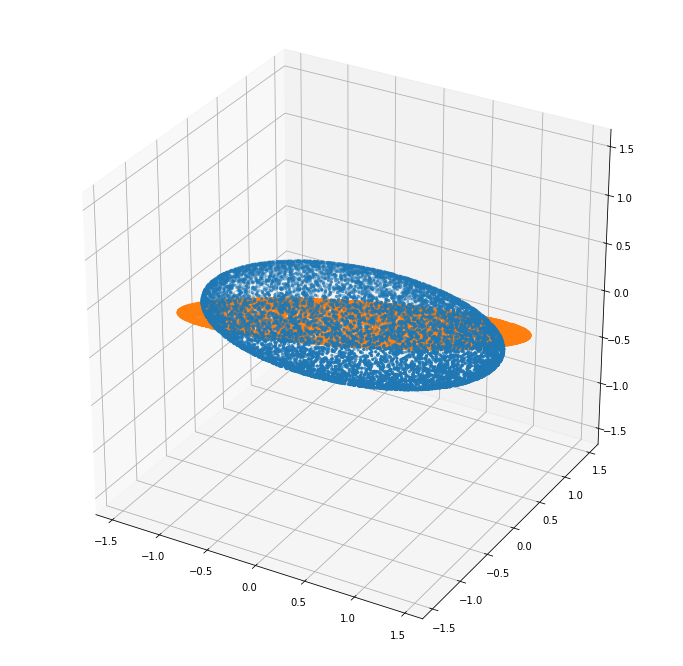

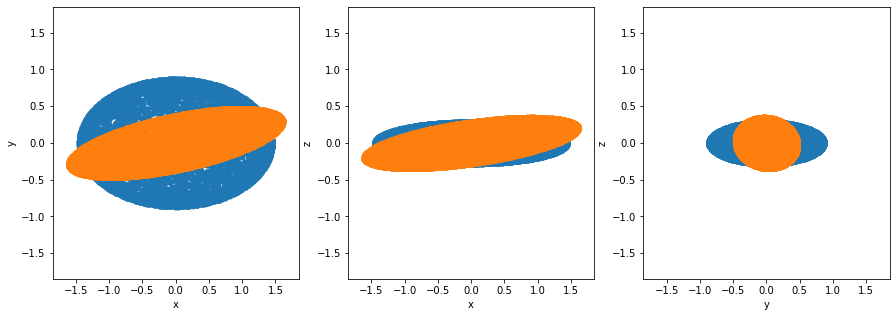

In [259]:


# 3D Ellipsoids ...
mean1 = [1,1,1]
cov1 = [[1, 0.85,0.55], 
        [0.85, 1,0.25],  
        [0.55, 0.25,1]]  
mean2 = [0,0,0]
cov2 = [[1, 0.45,0.35], 
        [0.45, 1,0.25],  
        [0.35, 0.25,1]]  

# 3D  
vals, vecs = eigsorted(cov1) 
vals, vecs = eigsorted(cov1) 
print('axis ratios = ',np.sqrt(vals))
print('vecs ...', type(vecs))
for v in vecs : print(v, ' : norm=', np.linalg.norm(v))

# 3D Plot 
print( "\n *** BUT THIS IS UNROTATED *** \n" )
fig = plt.figure(figsize=3.0*plt.figaspect(1.0)*1.0)
ax = fig.add_subplot(111, projection='3d')
a,b,c = np.sqrt(vals)
x,y,z=random_point_ellipsoid(a,b,c, 10000)
print(f'max values x,y,z = {np.max(x),np.max(y),np.max(z)}')
ax.scatter(x,y,z, marker='.')
axisEqual3D(ax)

# Rotate ...
T = vecs.dot(np.diag(np.sqrt(vals)))
print('T=',T)
XYZ = np.vstack((x, y, z)).T
TXYZ = XYZ.dot(T)
print(f'max values TXYZvyz = {np.max(TXYZ[:,0]),np.max(TXYZ[:,1]),np.max(TXYZ[:,2])}')
ax.scatter(TXYZ[:,0],TXYZ[:,1],TXYZ[:,2], marker='.')

# Projections 
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(x,y, marker='.') 
axs[1].scatter(x,z, marker='.')
axs[2].scatter(y,z, marker='.')
for ax,xd,yd in zip(axs,'xxy','yzz'):
    ax.set_xlim([-1.85,1.85])
    ax.set_ylim([-1.85,1.85])
    ax.set_xlabel(xd)
    ax.set_ylabel(yd)

axs[0].scatter(TXYZ[:,0],TXYZ[:,1], marker='.') 
axs[1].scatter(TXYZ[:,0],TXYZ[:,2], marker='.')
axs[2].scatter(TXYZ[:,1],TXYZ[:,2], marker='.')
    


# Sorted eig-vals & vecs: semi-major axis first
#vals, vecs = np.linalg.eigh(cov)
#order = vals.argsort()[::-1]
def cov2d (i,j,cov):
    return np.asarray([[cov[i][i],cov[i][j]],[cov[j][i],cov[j][j]]])
cov = cov2d(0,1,cov1)
print('cov=',cov)
vals, vecs = eigsorted(cov) 
print(vals, vecs)
print('axis ratios = ',np.sqrt(vals))
#phi  = np.arctan2(*vecs[:,0][::-1])



# 2D Example from ... 
https://janakiev.com/blog/covariance-matrix/

In [395]:
def plotSlices(axs, D,t):
    ''' Convenience func to generate 3 side-by-side plots '''
    Ndim   = D.shape[1]
    #print(f'Ndim={Ndim}, Nplots={Nplots}')
    n = -1 
    for ni in range(Ndim-1):
        for nj in range(ni+1,Ndim):
            n += 1
            axs[n].scatter(D[:, ni], D[:, nj], marker='.') 
            axs[n].axis('equal');
            axs[n].set_xlabel('dim:'+str(ni))
            axs[n].set_ylabel('dim:'+str(nj))
    axs[0].set_title(t)
    return axs

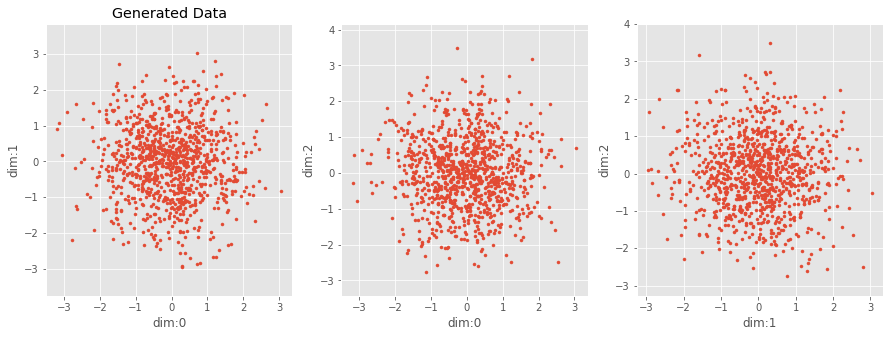

In [398]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)


# Normal distributed data with mean 0 and standard deviation 1
n = 1000 # Number of data samples 
N = 3    # Number of dimensions 
X = np.vstack(( np.random.normal(0, 1, n) for d in range(N) )).T 

# Plot 
Ndim   = X.shape[1]
Nplots =int( np.math.factorial(Ndim) / ( np.math.factorial(2)*np.math.factorial(Ndim-2) ) )
fig, axs = plt.subplots(1, Nplots, figsize=(15, 15/Nplots))
axs = plotSlices(axs, X,'Generated Data')


np.cov(X.T)=[[ 1.01945311 -0.03519956 -0.03000533]
 [-0.03519956  1.04937607 -0.03421274]
 [-0.03000533 -0.03421274  0.97668172]]
np.cov(Y.T)=[[ 4.99532022e-01 -8.37749448e-02 -2.10037321e-01]
 [-8.37749448e-02  1.21307874e+01 -1.16323325e+00]
 [-2.10037321e-01 -1.16323325e+00  9.76681716e+01]]


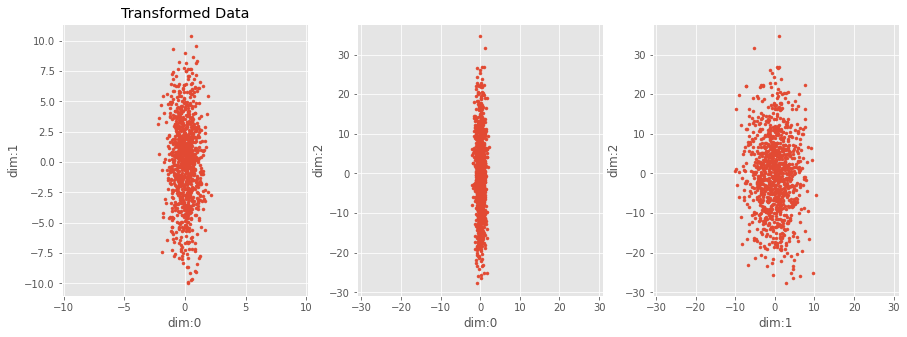

In [400]:
# Center the matrix at the origin
X = X - np.mean(X, 0)
print( f'np.cov(X.T)={np.cov(X.T)}')
      
# Scaling matrix
sx, sy, sz = 0.7, 3.4, 10.0
Scale = np.array([[sx, 0, 0], [0, sy,0],[0,0,sz]])

# Apply scaling matrix to X
Y = X.dot(Scale)

# Plot 
Ndim   = Y.shape[1]
Nplots =int( np.math.factorial(Ndim) / ( np.math.factorial(2)*np.math.factorial(Ndim-2) ) )
fig, axs = plt.subplots(1, Nplots, figsize=(15, 15/Nplots))
axs=plotSlices(axs,Y,'Transformed Data')

# Calculate covariance matrix
C = np.cov(Y.T)
print( f'np.cov(Y.T)={C}')


np.cov(Y.T)=[[ 48.30379819   4.92565052 -42.06585744]
 [  4.92565052   1.02510739  -5.00454121]
 [-42.06585744  -5.00454121  60.9695854 ]]


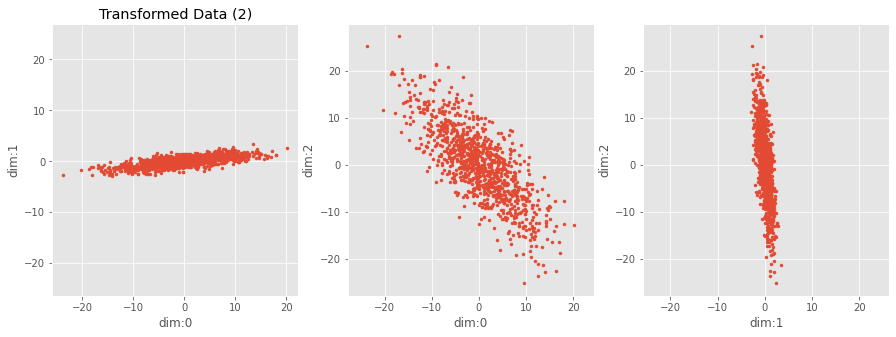

In [401]:
# Scaling matrix
sx, sy, sz = 0.7, 3.4, 10.0
Scale = np.array([[sx, 0, 0], [0, sy,0],[0,0,sz]])

# Rotation matrix
theta1,theta2,theta3, = 0.47*np.pi,0.77*np.pi,0.97*np.pi
c1, s1 = np.cos(theta1), np.sin(theta1)
c2, s2 = np.cos(theta2), np.sin(theta2)
c3, s3 = np.cos(theta3), np.sin(theta3)
Rot1 = np.array([[c1, -s1,0], [s1, c1,0],[0,0,1]])
Rot2 = np.array([[c2, 0,s2], [0,1,0], [-s2, 0, c2]])
Rot3 = np.array([[1,0,0], [0,c3, -s3],[0,s3,c3]])
Rot=Rot1.dot(Rot2).dot(Rot3)

# Transformation matrix
T = Scale.dot(Rot)

# Apply transformation matrix to X
Y = X.dot(T)

# Plot 
Ndim   = Y.shape[1]
Nplots =int( np.math.factorial(Ndim) / ( np.math.factorial(2)*np.math.factorial(Ndim-2) ) )
fig, axs = plt.subplots(1, Nplots, figsize=(15, 15/Nplots))
axs=plotSlices(axs, Y,'Transformed Data (2)')


# Calculate covariance matrix
C = np.cov(Y.T)
print( f'np.cov(Y.T)={C}')


np.cov(Z.T)=[[ 1.00000000e+00  1.15489867e-15 -4.84097247e-15]
 [ 1.15489867e-15  1.00000000e+00  9.34587743e-15]
 [-4.84097247e-15  9.34587743e-15  1.00000000e+00]]
eVa, eVe = (array([1., 1., 1.]), array([[ 0.25695287, -0.80131123, -0.56601238],
       [-0.60336502, -0.56047377,  0.53714157],
       [ 0.75493435, -0.20921153,  0.62538702]]))


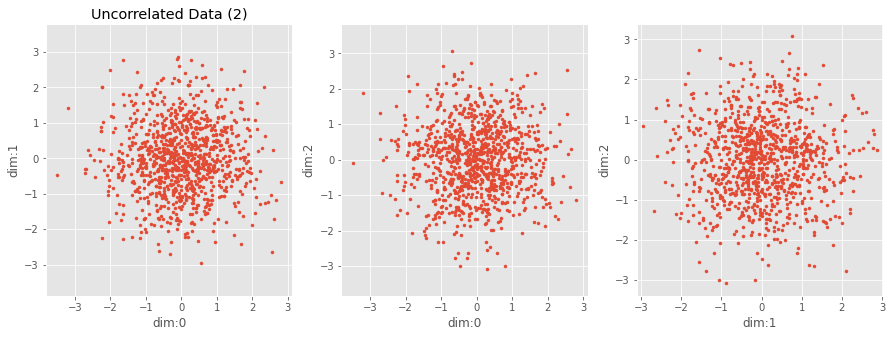

In [410]:
C = np.cov(Y.T)

# Calculate eigenvalues
eVa, eVe = np.linalg.eig(C)

# Calculate transformation matrix from eigen decomposition
R, S = eVe, np.diag(np.sqrt(eVa))
T = R.dot(S).T

# Transform data with inverse transformation matrix T^-1
Z = Y.dot(np.linalg.inv(T))

# Plot 
Ndim   = Z.shape[1]
Nplots =int( np.math.factorial(Ndim) / ( np.math.factorial(2)*np.math.factorial(Ndim-2) ) )
fig, axs = plt.subplots(1, Nplots, figsize=(15, 15/Nplots))
axs=plotSlices(axs,Z,'Uncorrelated Data (2)')



# Covariance matrix of the uncorrelated data
CZ = np.cov(Z.T)
print( f'np.cov(Z.T)={CZ}')
print(f'eVa, eVe = {np.linalg.eig(CZ)}')

np.cov(Y.T)=[[ 48.30379819   4.92565052 -42.06585744]
 [  4.92565052   1.02510739  -5.00454121]
 [-42.06585744  -5.00454121  60.9695854 ]]


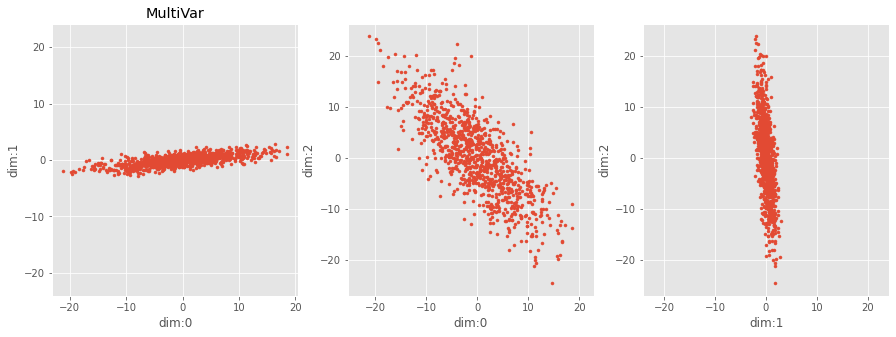

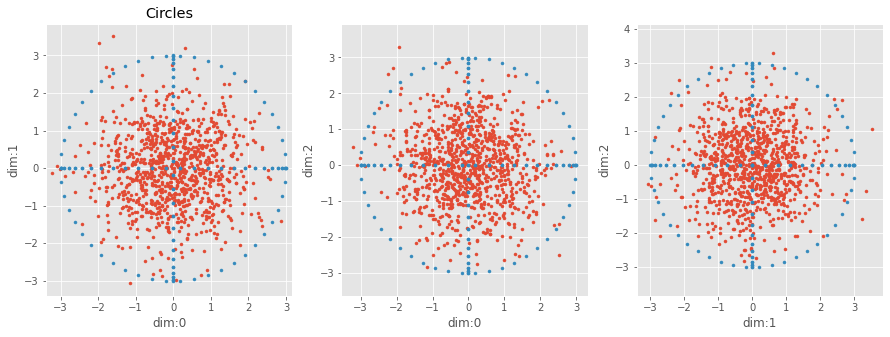

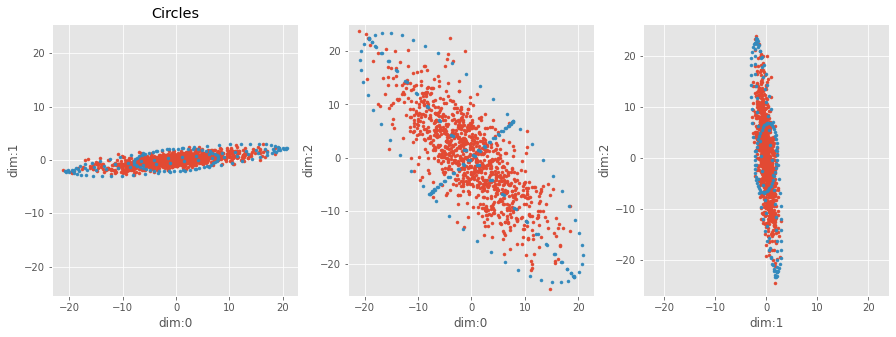

In [428]:
import itertools 

def generate_circle_points(n=20, Ndim=3, scale = 3 ):
    ''' There is presumably a quicker / more elegant way to do this ... '''
    t = 2*np.pi*np.sort(np.arange(n)/n) 
    c,s=np.cos(t), np.sin(t)
    
    default = [0*t for n in range(Ndim)]
    L = []
    for i,j in itertools.combinations( range(Ndim),2 ):
        arr = default.copy()
        arr[i] = c
        arr[j] = s
        L.append( scale*np.vstack(arr).T )
        
    return np.concatenate( L) 

# New sample with same covar as above 
print( f'np.cov(Y.T)={C}')
D = np.random.multivariate_normal( [0,0,0], C ,1000)

# Calculate eigenvalues
eVa, eVe = np.linalg.eig(C)

# Calculate transformation matrix from eigen decomposition
R, S = eVe, np.diag(np.sqrt(eVa)) # Rotn, Scale
T = R.dot(S).T

# Transform data with inverse transformation matrix T^-1
DZ = D.dot(np.linalg.inv(T))

# Plot D
Ndim   = D.shape[1]
Nplots =int( np.math.factorial(Ndim) / ( np.math.factorial(2)*np.math.factorial(Ndim-2) ) )
fig, axs = plt.subplots(1, Nplots, figsize=(15, 15/Nplots))
axs = plotSlices(axs, D,'MultiVar')

# Plot DZ
Ndim   = DZ.shape[1]
Nplots =int( np.math.factorial(Ndim) / ( np.math.factorial(2)*np.math.factorial(Ndim-2) ) )
fig, axs = plt.subplots(1, Nplots, figsize=(15, 15/Nplots))
axs=plotSlices(axs,DZ,'MultiVar Back to Unit')

# Circles to be transformed ...
circlePoints = generate_circle_points(n=50)

axs=plotSlices( axs, circlePoints, 'Circles')

# Plot re-transformed DZ ...
Ndim   = DZ.shape[1]
Nplots =int( np.math.factorial(Ndim) / ( np.math.factorial(2)*np.math.factorial(Ndim-2) ) )
fig, axs = plt.subplots(1, Nplots, figsize=(15, 15/Nplots))
axs = plotSlices(axs, DZ.dot(T),'MultiVar')
axs = plotSlices(axs, circlePoints.dot(T),'Circles')



# 6D

cov=[[1, 0.85, 0.65, 0.45], [0.85, 1, 0.75, 0.55], [0.65, 0.75, 1, 0.93], [0.45, 0.55, 0.93, 1]]
eVa=[3.09881185 0.72885423 0.1413355  0.03099843], eVe=[[-0.47479351 -0.57218705 -0.66607186  0.05934125]
 [-0.50915105 -0.40579079  0.73003557  0.20771884]
 [-0.53905581  0.33315976  0.02918314 -0.77302765]
 [-0.4740835   0.63003206 -0.15014892  0.59645599]]
R=[[-0.47479351 -0.57218705 -0.66607186  0.05934125]
 [-0.50915105 -0.40579079  0.73003557  0.20771884]
 [-0.53905581  0.33315976  0.02918314 -0.77302765]
 [-0.4740835   0.63003206 -0.15014892  0.59645599]], S=[[1.76034424 0.         0.         0.        ]
 [0.         0.8537296  0.         0.        ]
 [0.         0.         0.37594613 0.        ]
 [0.         0.         0.         0.1760637 ]]
[[-0.83580002 -0.89628112 -0.94892379 -0.83455015]
 [-0.48849302 -0.3464356   0.28442835  0.53787701]
 [-0.25040714  0.27445405  0.01097129 -0.05644791]
 [ 0.01044784  0.03657175 -0.13610211  0.10501425]]


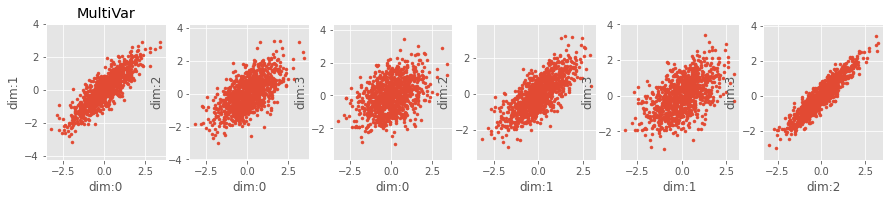

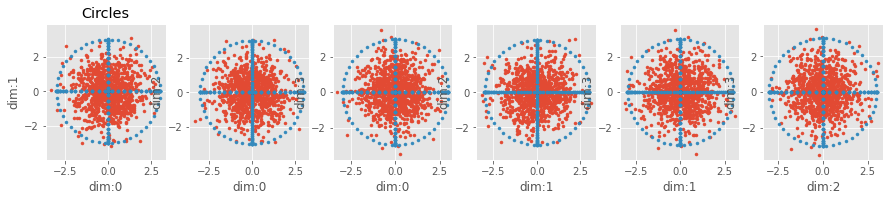

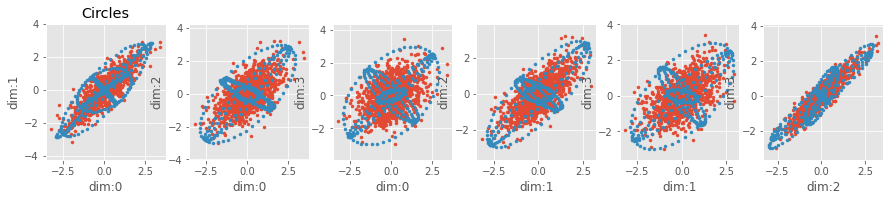

In [447]:
mean = [0,0,0,0,0,0]
cov  = [[1,    0.85,0.65,0.45,0.25,0.05], 
        [0.85, 1,   0.75,0.55,0.35,0.15],  
        [0.65, 0.75,1,   0.3, 0.2, 0.1],
        [0.45, 0.55,0.3, 1,   0.6, 0.7], 
        [0.25, 0.35,0.2, 0.6, 1,   0.9],  
        [0.05, 0.15,0.1, 0.7, 0.9, 1]
       ]  
mean = [0,0,0,0]
cov  = [[1,    0.85,0.65,0.45], 
        [0.85, 1,   0.75,0.55],  
        [0.65, 0.75,1,   0.93],
        [0.45, 0.55,0.93, 1]
       ]  


# New sample with same covar as above 
print( f'cov={cov}')
D = np.random.multivariate_normal( mean, cov ,1000)

# Calculate eigenvalues
eVa, eVe = np.linalg.eig(cov)
print(f'eVa={eVa}, eVe={eVe}')
# Calculate transformation matrix from eigen decomposition
R, S = eVe, np.diag(np.sqrt(eVa)) # Rotn, Scale
print(f'R={R}, S={S}')
T = R.dot(S).T
print(T)
# Transform data with inverse transformation matrix T^-1
DZ = D.dot(np.linalg.inv(T))

# Plot D
Ndim   = D.shape[1]
Nplots =int( np.math.factorial(Ndim) / ( np.math.factorial(2)*np.math.factorial(Ndim-2) ) )
fig, axs = plt.subplots(1, Nplots, figsize=(15, 15/Nplots))
axs = plotSlices(axs, D,'MultiVar')

# Plot DZ
Ndim   = DZ.shape[1]
Nplots =int( np.math.factorial(Ndim) / ( np.math.factorial(2)*np.math.factorial(Ndim-2) ) )
fig, axs = plt.subplots(1, Nplots, figsize=(15, 15/Nplots))
axs=plotSlices(axs,DZ,'MultiVar Back to Unit')

# Circles to be transformed ...
circlePoints = generate_circle_points(n=50, Ndim=Ndim)
axs=plotSlices( axs, circlePoints, 'Circles')

# Plot re-transformed DZ ...
Ndim   = DZ.shape[1]
Nplots =int( np.math.factorial(Ndim) / ( np.math.factorial(2)*np.math.factorial(Ndim-2) ) )
fig, axs = plt.subplots(1, Nplots, figsize=(15, 15/Nplots))
axs = plotSlices(axs, DZ.dot(T),'MultiVar')
axs = plotSlices(axs, circlePoints.dot(T),'Circles')



In [487]:
from functools import lru_cache

In [495]:
%%time 
@lru_cache(maxsize=8)
def generate_circle_points(n=20, Ndim=3, scale = 3 ):
    ''' There is presumably a quicker / more elegant way to do this ... '''
    t = np.linspace(0,2*np.pi,n)
    c,s=np.cos(t), np.sin(t)
    
    default = [0*t for n in range(Ndim)]
    L = []
    for i,j in itertools.combinations( range(Ndim),2 ):
        arr = default.copy()
        arr[i] = c
        arr[j] = s
        L.append( np.vstack(arr).T )
        print(i,j,L[-1].shape)
        
    return scale*np.concatenate( L) 


n = 100
s = np.sum([generate_circle_points().shape[0] for i in range(n) ] )
print(f's={s}, <>={s/n}')

0 1 (20, 3)
0 2 (20, 3)
1 2 (20, 3)
s=6000, <>=60.0
CPU times: user 804 µs, sys: 317 µs, total: 1.12 ms
Wall time: 876 µs


In [499]:
generate_circle_points.cache_clear()
generate_circle_points()

...
0 1 (20, 3)
0 2 (20, 3)
1 2 (20, 3)


array([[ 3.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.83745173e+00,  9.74098408e-01,  0.00000000e+00],
       [ 2.36742153e+00,  1.84263814e+00,  0.00000000e+00],
       [ 1.64084447e+00,  2.51149943e+00,  0.00000000e+00],
       [ 7.36456461e-01,  2.90820080e+00,  0.00000000e+00],
       [-2.47738036e-01,  2.98975348e+00,  0.00000000e+00],
       [-1.20508627e+00,  2.74731998e+00,  0.00000000e+00],
       [-2.03184471e+00,  2.20717173e+00,  0.00000000e+00],
       [-2.63842125e+00,  1.42784218e+00,  0.00000000e+00],
       [-2.95908391e+00,  4.93783771e-01,  0.00000000e+00],
       [-2.95908391e+00, -4.93783771e-01,  0.00000000e+00],
       [-2.63842125e+00, -1.42784218e+00,  0.00000000e+00],
       [-2.03184471e+00, -2.20717173e+00,  0.00000000e+00],
       [-1.20508627e+00, -2.74731998e+00,  0.00000000e+00],
       [-2.47738036e-01, -2.98975348e+00,  0.00000000e+00],
       [ 7.36456461e-01, -2.90820080e+00,  0.00000000e+00],
       [ 1.64084447e+00, -2.51149943e+00